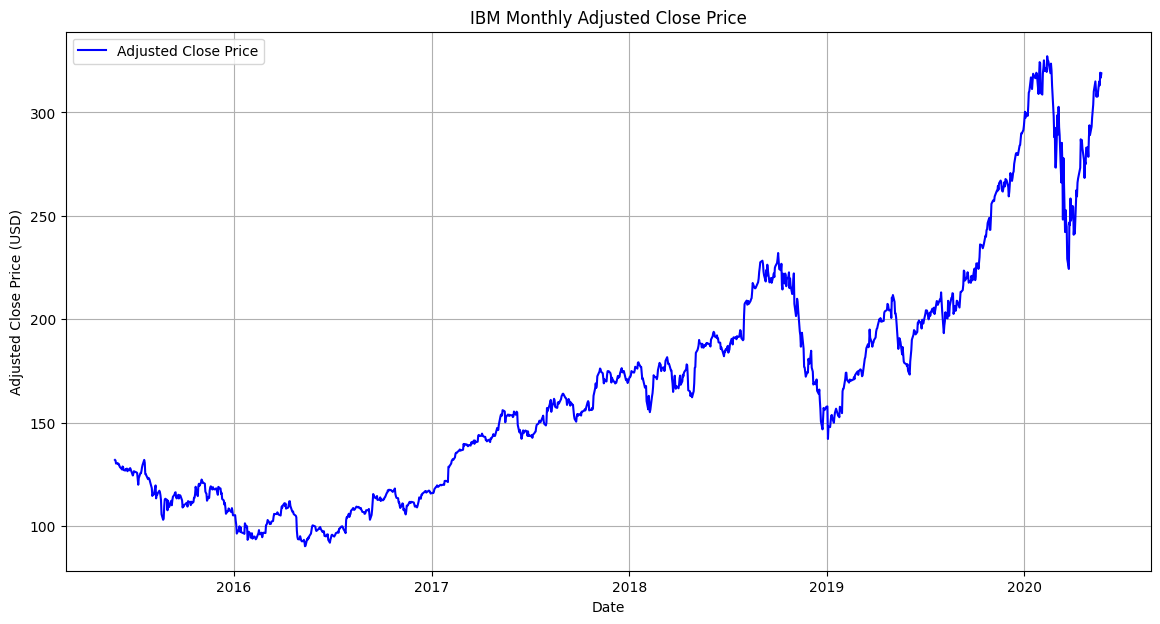

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
file_path = './AAPL.csv'
df = pd.read_csv(file_path)

# Convert 'date' to datetime format
df['date'] = pd.to_datetime(df['date'])

# Sort the data by date
df = df.sort_values('date')

# Set the 'date' column as the index
df.set_index('date', inplace=True)

# Plotting
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['close'], label='Adjusted Close Price', color='blue')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price (USD)')
plt.title('IBM Monthly Adjusted Close Price')
plt.legend()
plt.grid(True)
plt.show()

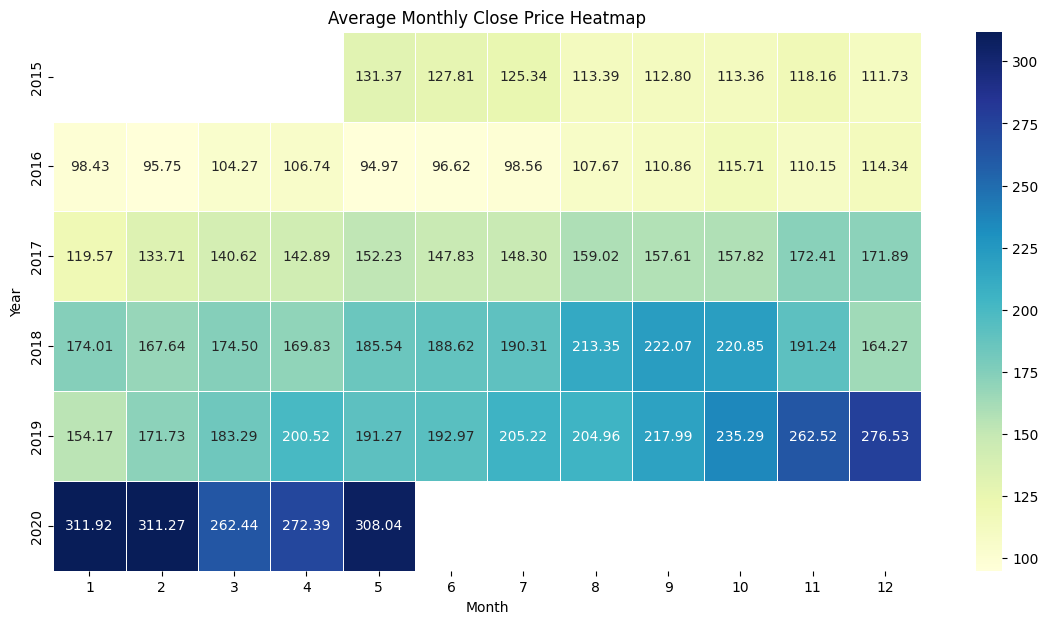

In [2]:
# Load the data
file_path = './AAPL.csv'
df = pd.read_csv(file_path)
# Convert 'date' to datetime format
df['date'] = pd.to_datetime(df['date'])

# Sort the data by date
df = df.sort_values('date')

# Set the 'date' column as the index
df.set_index('date', inplace=True)

# Extract year and month
df['year'] = df.index.year
df['month'] = df.index.month

# Aggregate the data to get the average close price for each year and month
heatmap_data = df.pivot_table(values='close', index='year', columns='month', aggfunc='mean')

# Plotting the heatmap
plt.figure(figsize=(14, 7))
sns.heatmap(heatmap_data, cmap='YlGnBu', annot=True, fmt=".2f", linewidths=.5)
plt.xlabel('Month')
plt.ylabel('Year')
plt.title('Average Monthly Close Price Heatmap')
plt.show()


In [52]:
#cleaning the data
def load_and_clean_data(file_path):
    df = pd.read_csv(file_path)
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values('date')
    df.set_index('date', inplace=True)
    return df.dropna()


In [53]:
from sklearn.preprocessing import MinMaxScaler

def normalize_data(df):
    data = df.filter(['close'])
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data)
    return scaled_data, scaler

# Normalize the data
scaled_data, scaler = normalize_data(df)


In [54]:
def split_data(scaled_data, train_size=0.7, val_size=0.15):
    train_len = int(len(scaled_data) * train_size)
    val_len = int(len(scaled_data) * val_size)
    train_data = scaled_data[:train_len]
    val_data = scaled_data[train_len:train_len + val_len]
    test_data = scaled_data[train_len + val_len:]
    return train_data, val_data, test_data

# Split the data
train_data, val_data, test_data = split_data(scaled_data)


In [55]:
import numpy as np
def prepare_data(data, time_step=60):
    x, y = [], []
    for i in range(time_step, len(data)):
        x.append(data[i-time_step:i, 0])
        y.append(data[i, 0])
    x, y = np.array(x), np.array(y)
    x = np.reshape(x, (x.shape[0], x.shape[1], 1))
    return x, y

# Prepare training data
x_train, y_train = prepare_data(train_data)

# Prepare validation data
x_val, y_val = prepare_data(val_data)


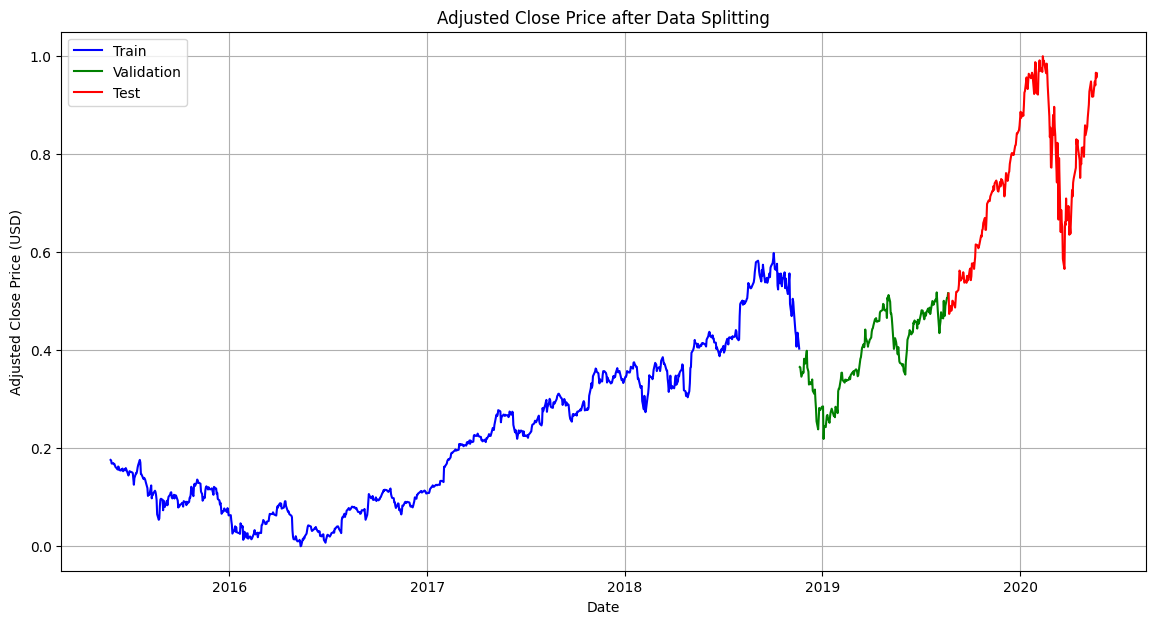

In [57]:
# Plotting the data after splitting
plt.figure(figsize=(14, 7))

# Plot training data
plt.plot(df.index[:len(train_data)], train_data, label='Train', color='blue')

# Plot validation data
plt.plot(df.index[len(train_data):len(train_data) + len(val_data)], val_data, label='Validation', color='green')

# Plot test data
plt.plot(df.index[len(train_data) + len(val_data):], test_data, label='Test', color='red')

plt.xlabel('Date')
plt.ylabel('Adjusted Close Price (USD)')
plt.title('Adjusted Close Price after Data Splitting')
plt.legend()
plt.grid(True)
plt.show()


In [58]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

def build_stacked_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=100, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.5))
    model.add(LSTM(units=100, return_sequences=True))
    model.add(Dropout(0.5))
    model.add(LSTM(units=100))
    model.add(Dropout(0.5))
    model.add(Dense(units=1))
    optimizer = Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Build the model
model = build_stacked_lstm_model((x_train.shape[1], 1))


In [63]:
# Train the model
model.fit(x_train, y_train, epochs=200, batch_size=64, validation_data=(x_val, y_val), verbose=1)


Epoch 1/200
13/13 [==============================] - 5s 380ms/step - loss: 0.0016 - val_loss: 0.0012
Epoch 2/200
13/13 [==============================] - 4s 257ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 3/200
13/13 [==============================] - 3s 260ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 4/200
13/13 [==============================] - 3s 263ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 5/200
13/13 [==============================] - 5s 390ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 6/200
13/13 [==============================] - 3s 256ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 7/200
13/13 [==============================] - 3s 259ms/step - loss: 0.0016 - val_loss: 0.0011
Epoch 8/200
13/13 [==============================] - 5s 367ms/step - loss: 0.0015 - val_loss: 0.0011
Epoch 9/200
13/13 [==============================] - 4s 273ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 10/200
13/13 [==============================] - 3s 262ms/step - loss: 0.0014 - val_lo

5/5 [==============================] - 0s 53ms/step


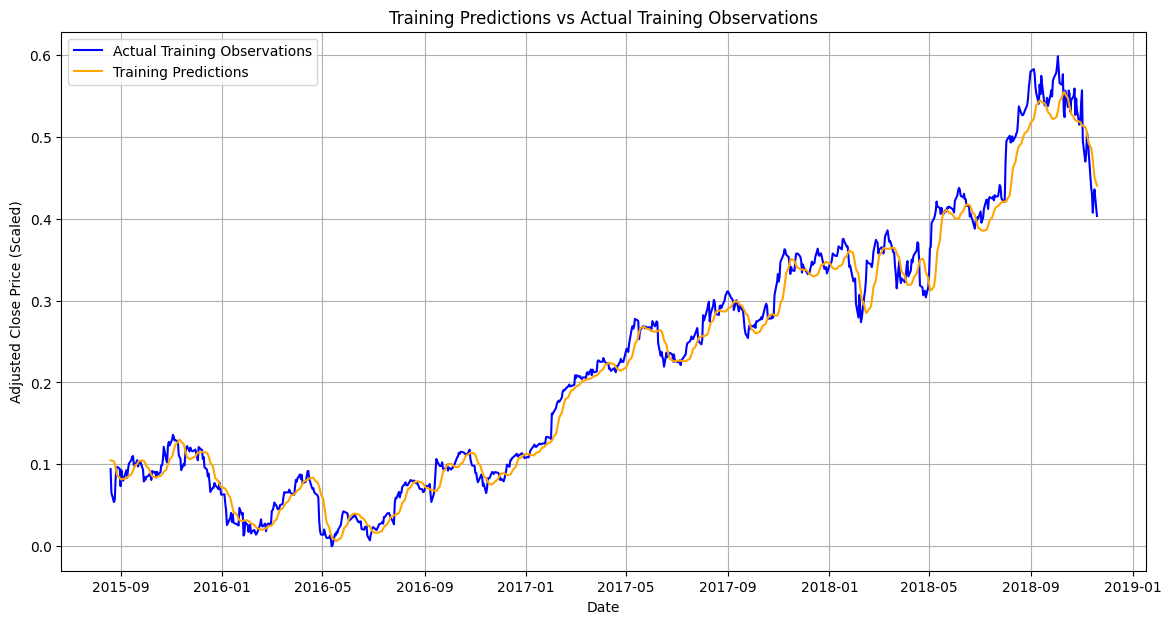

In [66]:
# Make predictions on training data
train_predictions = model.predict(x_train)

# Prepare testing data and corresponding actual values
x_test, y_test_actual = prepare_data(test_data)

# Make predictions on test data
test_predictions = model.predict(x_test)


# Plotting training predictions against actual training observations
plt.figure(figsize=(14, 7))
plt.plot(df.index[60:60+len(y_train)], y_train, label='Actual Training Observations', color='blue')
plt.plot(df.index[60:60+len(train_predictions)], train_predictions, label='Training Predictions', color='orange')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price (Scaled)')
plt.title('Training Predictions vs Actual Training Observations')
plt.legend()
plt.grid(True)
plt.show()


In [67]:
# Make predictions on training data
train_predictions = model.predict(x_train)

# Prepare testing data and corresponding actual values
x_test, y_test_actual = prepare_testing_data(test_data)

# Make predictions on test data
test_predictions = model.predict(x_test)

# Calculate RMSE and MSE for training data
train_rmse, train_mse = calculate_metrics(y_train, train_predictions)
print(f'Training RMSE(Root mean squared error): {train_rmse}')
print(f'Training MSE(Mean squared error): {train_mse}')

# Calculate RMSE and MSE for test data
test_rmse, test_mse = calculate_metrics(y_test_actual, test_predictions)
print(f'Test RMSE(Root mean squared error): {test_rmse}')
print(f'Test MSE(Mean squared error): {test_mse}')


5/5 [==============================] - 0s 36ms/step
Training RMSE(Root mean squared error): 0.020957600730937394
Training MSE(Mean squared error): 0.00043922102839738763
Test RMSE(Root mean squared error): 0.08428734741758978
Test MSE(Mean squared error): 0.007104356934693478


In [68]:
import pickle

# Serialize (save) the trained model
def save_model(model, filename):
    with open(filename, 'wb') as file:
        pickle.dump(model, file)

# Deserialize (load) the saved model
def load_model(filename):
    with open(filename, 'rb') as file:
        model = pickle.load(file)
    return model


# Saving  the trained model
save_model(model, 'trained_model.pkl')

# Loading the saved model
loaded_model = load_model('trained_model.pkl')
